In [1]:
import os
from datetime import datetime
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get correct directory
os.chdir('/content/drive/MyDrive/Love Hackathon')

In [ ]:
#from .py
import utils

# Functions

In [ ]:
def multi_cat_val_handler(df, cols_list):
  '''
  Turn single feature with multiple values into machine readable form
  cleaned = df['Hobby (Select 3)'].str.split(';', expand=True).stack()
  pd.get_dummies(cleaned, prefix='h').groupby(level=0).sum()
  '''

  for col in cols_list:
    prefix = col[0].lower() #first alphabet
    cleaned = df[col].str.split(';', expand=True).stack()
    temp_df = pd.get_dummies(cleaned, prefix=prefix).groupby(level=0).sum()
    df = df.join(temp_df)
    df.drop(col, axis=1, inplace=True)

  return df

def check_df(df, show_all=False, show_unique=False):
    null_exist =False
    for col in df.columns:
        if show_all or df[col].isna().values.sum() != 0:
            print(f'{col}: null={df[col].isna().values.sum()}, dtypes={df[col].dtypes}')
            if show_unique:
                print(f'{col}:', df[col].unique())
            if df[col].isna().values.sum() != 0:
                null_exist =True
    
    if not null_exist:
        print('No null exist in this dataframe.')

#evaluation
'''
https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd
'''

def alpha_evaluation_score(y_true, y_pred):
    alpha = 1
    beta = 0.25
    gamma = 1
    
    # compute true positives across training examples and labels
    tp = np.sum(np.logical_and(y_true, y_pred))
    
    # compute false negatives (Missed Labels) across training examples and labels
    fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
    
    # compute False Positive across training examples and labels.
    fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
        
    # Compute alpha evaluation score
    alpha_score = (1 - ((beta * fn + gamma * fp ) / (tp +fn + fp + 0.00001)))**alpha 
    
    return alpha_score

In [ ]:
#read df
df = pd.read_csv('data/Demographic to Gift Preference Survey.csv')

#convert to correct dtypes
df['Birthday'] = df['Birthday'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))

#create necessary columns
df['Age'] = datetime.now().year - df['Birthday'].apply(lambda x: x.year)

#remove outliers
df['Age'] = df['Age'].apply(lambda x: x if (x >18 and x <60) else df['Age'].median()) #use median to impute age

#remove unnecessary columns
df = df.drop(['Timestamp', 'Birthday', 'Relationship Period (Starting Date)'], axis=1)

#rename for readability
df.rename(columns={'Hobby (Select 3)': 'Hobby', 'Gift Preferences (Choose 3)': 'Gift Preferences'}, inplace=True)

#Handle single feature with multiple values through one-hot encoding
multi_val_cols = ['Hobby', 'Movie Preferences', 'Gift Preferences']
new_df = multi_cat_val_handler(df, multi_val_cols)
new_df = pd.get_dummies(new_df, drop_first=True)

#remove weird col
new_df.drop(['g_A smile HAHAHAHA'], axis=1, inplace=True)
new_df.drop(['g_I would choose all'], axis=1, inplace=True)

#remove NAN in movie - NAN means they don't like all movie 
for col in new_df.columns:
  if col.startswith('m_'):
    new_df[col] = new_df[col].fillna(0)

In [ ]:
def get_count_val(df):
  col_list = df.columns
  col_val = []
  for col in df.columns:
    col_val.append( df[col].value_counts()[1])

  plt.barh(col_list, col_val)
  plt.title('Gift Preferences')
  plt.xlabel('Label count')
  plt.show()

In [ ]:
# get_count_val(y)

NameError: ignored

In [ ]:
# y[y.columns[0]].value_counts()

0    71
1     8
Name: g_Accompaniment (Pets, etc..), dtype: int64

In [ ]:
# get_count_val(y)

In [ ]:
#check NA
# new_df[(new_df.isnull().any(axis=1))]

In [ ]:
new_df.describe()

,Height (cm),Weight (kg),Age,"h_Arts & Crafts (embroidery, knitting, drawing)","h_Collecting (stamps, coins)",h_Games (board and computer games),"h_Model & Electronic (tinkering electronics, cars)",h_Music (performing or listening),"h_Performing Arts (drawing, sculpting, cooking)","h_Spiritual and Mental (meditation, self-enrichment sessions)",h_Sports & Outdoors (e-sports doesn't count),m_Action,m_Comedy,m_Drama,m_Fantasy,m_Horror,m_Mystery,m_Romance,m_Thriller,m_Western,"g_Accompaniment (Pets, etc..)",g_Cash,"g_Cosmetics (Lipstick, perfumes, etc..)",g_Fitness/ Sports Gadgets,g_Flower,g_Food and Snacks,"g_Hand Made Gift (handmade photobook, etc..)",g_I would choose all,"g_Jewelry (Necklace, Ring, etc..)","g_Outfit (T-shirt, shoes, etc..)",g_Stationery,g_Technology Gadgets,g_Vacation,Sex_Male,Horoscope_Aries (Mar 21-Apr 19),Horoscope_Cancer (Jun 21-Jul 22),Horoscope_Capricorn (Dec 22-Jan 19),Horoscope_Gemini (May 21-Jun 20),Horoscope_Leo (July 23-Aug 22),Horoscope_Libra (Sep 23-Oct 22),Horoscope_Pisces (Feb 19-Mar 20),Horoscope_Sagittarius (Nov 22-Dec 21),Horoscope_Scorpio (Oct 23-Nov 21),Horoscope_Taurus (Apr 20-May 20),Horoscope_Virgo (Aug 23-Sep 22),Body State_Fat,Body State_Muscular,Body State_Normal,Body State_Slightly overweight,Body State_Slim,Relationship Status_Married,Relationship Status_Single,"Hometown _East Coast Region: Kelantan, Terengganu, Pahang,","Hometown _East Malaysia: Sabah, Sarawak","Hometown _Northern Region: Perlis, Kedah, Penang, Perak.",Hometown _Others,"Hometown _Southern Region: Negeri Sembilan, Malacca, Johor.",Favourite Colour_Blue,Favourite Colour_Green,Favourite Colour_Indigo,Favourite Colour_Orange,Favourite Colour_Purple,Favourite Colour_Red,Favourite Colour_White,Favourite Colour_Yellow,Field of Work/ Study_Science,Family Economy Status_M40 (Middle 40%),Family Economy Status_T20 (Top 20%),How do you get your energy?_I,How do you see the world and gather information. _S,How do you make your decisions_T,How much do you plan ahead?_P
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.00000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,164.569620,56.074684,21.987342,0.341772,0.037975,0.544304,0.151899,0.759494,0.291139,0.240506,0.632911,0.531646,0.658228,0.531646,0.329114,0.240506,0.455696,0.481013,0.303797,0.177215,0.101266,0.316456,0.164557,0.177215,0.088608,0.417722,0.316456,0.012658,0.126582,0.278481,0.101266,0.493671,0.392405,0.468354,0.088608,0.139241,0.063291,0.050633,0.063291,0.037975,0.037975,0.075949,0.151899,0.139241,0.075949,0.012658,0.063291,0.670886,0.012658,0.227848,0.012658,0.759494,0.227848,0.025316,0.379747,0.012658,0.253165,0.21519,0.050633,0.025316,0.012658,0.164557,0.088608,0.189873,0.050633,0.721519,0.632911,0.050633,0.683544,0.645570,0.607595,0.518987
std,7.799874,11.080457,1.031475,0.477334,0.192356,0.501216,0.361216,0.430122,0.457190,0.430122,0.485091,0.502186,0.477334,0.502186,0.472894,0.430122,0.501216,0.502832,0.462835,0.384291,0.303608,0.468065,0.373149,0.384291,0.285992,0.496335,0.468065,0.112509,0.334629,0.451116,0.303608,0.503155,0.491406,0.502186,0.285992,0.348409,0.245042,0.220648,0.245042,0.192356,0.192356,0.266610,0.361216,0.348409,0.266610,0.112509,0.245042,0.472894,0.112509,0.422124,0.112509,0.430122,0.422124,0.158088,0.488425,0.112509,0.437603,0.41358,0.220648,0.158088,0.112509,0.373149,0.285992,0.394707,0.220648,0.451116,0.485091,0.220648,0.

In [ ]:
# new_df.shape

In [ ]:
# new_df.head()

In [ ]:
check_df(new_df, show_unique=True)

No null exist in this dataframe.


Text(0, 0.5, 'Participants')

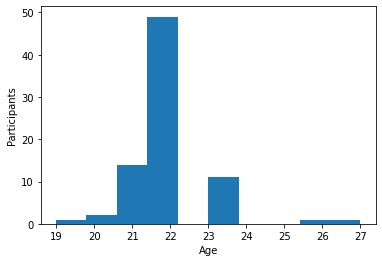

In [ ]:
# plt.hist(new_df['Age'])
# plt.xlabel('Age')
# plt.ylabel('Participants')

# Train & Test Datasets

In [ ]:
mask = new_df.columns.str.contains(r'g_.*')
y = new_df.iloc[:, mask]
X_prev = new_df.drop(y.columns, axis=1)

from sklearn import preprocessing
X = preprocessing.scale(X_prev)

In [ ]:
corr_df = pd.concat([X_prev, y], axis=1)
corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

best score: 0.698275896749897, with k=12


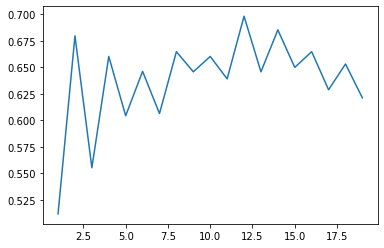

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kn_list = range(1,20)
max_score = best_kn = 0
score = []
for kn in kn_list:

  neigh = KNeighborsClassifier(n_neighbors=kn)
  neigh.fit(X_train, y_train)

  y_pred = neigh.predict(X_test)
  y_true = y_test.to_numpy()
  test_score = alpha_evaluation_score(y_true, y_pred)
  score.append(test_score)

  if test_score > max_score:
    max_score = test_score
    best_kn = kn

# print(neigh.predict([[1.1]]))
# print(neigh.predict_proba([[0.9]]))
plt.plot(kn_list, score)
print(f'best score: {max_score}, with k={best_kn}')

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)

In [ ]:
f1(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.11120267>

In [ ]:
utils.confusion_matrix(y_true, y_pred)

Confusion Matrix
 [[327  35]
 [ 91  27]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         2
           5       0.33      0.77      0.47        13
           6       0.36      0.44      0.40         9
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         4
          10       0.62      0.76      0.68        17
          11       0.00      0.00      0.00        19

   micro avg       0.44      0.23      0.30       118
   macro avg       0.11      0.16      0.13       118
weighted avg       0.15      0.23      0.18       118
 samples avg       0.37      0.23      0.27       118



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
utils.multilabel_confusion_matrix(y_true, y_pred)

array([[[33,  0],
        [ 7,  0]],

       [[24,  0],
        [16,  0]],

       [[34,  0],
        [ 6,  0]],

       [[33,  0],
        [ 7,  0]],

       [[38,  0],
        [ 2,  0]],

       [[ 7, 20],
        [ 3, 10]],

       [[24,  7],
        [ 5,  4]],

       [[39,  0],
        [ 1,  0]],

       [[35,  0],
        [ 5,  0]],

       [[27,  0],
        [13,  0]],

       [[36,  0],
        [ 4,  0]],

       [[15,  8],
        [ 4, 13]],

       [[21,  0],
        [19,  0]]])

# Deep Learning

In [ ]:
'''
https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
https://www.tensorflow.org/tutorials/quickstart/beginner
https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

'''

import tensorflow as tf
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from prettytable import ALL
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(80, input_dim=X.shape[1], activation='relu'))
model.add(Dense(54, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss=f1_loss, metrics=['accuracy', f1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 80)                5040      
_________________________________________________________________
dense_7 (Dense)              (None, 54)                4374      
_________________________________________________________________
dense_8 (Dense)              (None, 12)                660       
_________________________________________________________________
dense_9 (Dense)              (None, 13)                169       
Total params: 10,243
Trainable params: 10,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y.shape

(130, 13)

In [ ]:
y_train = y_train.astype('float32')

In [ ]:
model.fit(X_train, y_train, epochs=300)

Epoch 1/300
4/4 [==============================] - 0s 4ms/step - loss: 0.1100 - accuracy: 0.8462 - f1: 0.8869
Epoch 2/300
4/4 [==============================] - 0s 4ms/step - loss: 0.1287 - accuracy: 0.8173 - f1: 0.8293
Epoch 3/300
4/4 [==============================] - 0s 4ms/step - loss: 0.1110 - accuracy: 0.8365 - f1: 0.8691
Epoch 4/300
4/4 [==============================] - 0s 3ms/step - loss: 0.1326 - accuracy: 0.8750 - f1: 0.8172
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.8846 - f1: 0.8716
Epoch 6/300
4/4 [==============================] - 0s 4ms/step - loss: 0.1096 - accuracy: 0.8269 - f1: 0.8792
Epoch 7/300
4/4 [==============================] - 0s 5ms/step - loss: 0.1215 - accuracy: 0.8269 - f1: 0.8455
Epoch 8/300
4/4 [==============================] - 0s 4ms/step - loss: 0.1528 - accuracy: 0.8654 - f1: 0.8021
Epoch 9/300
4/4 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.8846 - f1: 0.8382
Epoch 10/3

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.where(y_pred >= 0.5, 1, 0)

In [ ]:
f1(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.19022703>

In [ ]:
utils.confusion_matrix(y_true, y_pred)

Confusion Matrix
 [[215  45]
 [ 54  24]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        10
           2       0.33      0.12      0.18         8
           3       0.33      0.25      0.29         4
           4       0.00      0.00      0.00         1
           5       0.44      0.64      0.52        11
           6       0.23      0.50      0.32         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         0
           9       0.14      0.20      0.17         5
          10       0.00      0.00      0.00         1
          11       0.47      0.70      0.56        10
          12       0.80      0.31      0.44        13

   micro avg       0.35      0.31      0.33        78
   macro avg       0.21      0.21      0.19        78
weighted avg       0.33      0.31      0.29        78
 samples avg       0.39      0.31      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pltX = []
pltY = []

for name2,data2 in second.items():

    row = [name2]
    for name1,data1 in first.items():
        data = np.stack((data1, data2), axis=1)
        loss = K.eval(f1_loss(Y, data))
        f1 = f1_score(Y, data, average='macro')
        pltX.append(loss)
        pltY.append(f1)
        row.append('{:2f}\n{:2f}'.format(loss, f1))